# Subsetting Dataset Stored in AWS with OPeNDAP

This notebook was developed following the workflow defined in Mike Gangl's "MUR-OPeNDAP" notebook, located here: https://github.com/podaac/tutorials/blob/master/notebooks/opendap/MUR-OPeNDAP.ipynb
<br/>
while also using code from Jack McNelis's "Co-locate satellite and in-situ data for cross-validation" file, located here: https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Colocate_satellite_insitu_ocean.ipynb

**Goal**
<br/>
To access the MUR 1-km dataset stored on Amazon Web Services (AWS) and to download that entire dataset to the local machine.

**Dataset**
<br/>
MUR 1-km L4 SST (requires AWS early access in order to view on Earthdata Search) https://podaac.jpl.nasa.gov/MEaSUREs-MUR?tab=background&sections=about%2Bdata

### Import Modules

In [1]:
from netCDF4 import Dataset
from urllib import request, parse
from platform import system
from os.path import join, expanduser, basename
from getpass import getpass
from netrc import netrc
from http.cookiejar import CookieJar
import xarray as xr
import dask
import requests
import json
import os

### Earthdata Login
<br/>
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The setup_earthdata_login_auth function will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

    machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>

Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

    $ chmod 0600 ~/.netrc

In [2]:
cmr = 'cmr.earthdata.nasa.gov'
edl = 'urs.earthdata.nasa.gov'
TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str=cmr):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


def setup_earthdata_login_auth(endpoint: str=edl):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint=cmr)

# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint=edl)

Username: Matthew.A.Thompson
Password: ········


### Period of Interest

In [3]:
start_date = "2019-01-01"
end_date   = "2019-01-02"

### Find Dataset Concept-Id
<br/>
OPeNDAC requires a dataset identifier that we must obtain from the Common Metadata Repository (CMR). In the next cell, submit a request to the CMR to grab the metadata for to the dataset/collection.

In [4]:
mur_results = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': "MUR-JPL-L4-GLOB-v4.1",
            'token': _token}
).json()

# Select the first/only record in the JSON response:
mur_coll = mur_results['items'][0]

# Select the 'concept-id' from the 'meta' dictionary:
mur_ccid = mur_coll['meta']['concept-id']

mur_ccid

'C1996881146-POCLOUD'

### Find Granule URLs using CMR
<br/>
The next cell joins the base CMR url with the specified subset values in order to find matching granule URLs.

In [5]:
cmr_url = "https://cmr.earthdata.nasa.gov"
req = requests.get(cmr_url + "/search/granules.umm_json?collection_concept_id=" + 
                    mur_ccid + "&temporal=" + start_date + "T10:00:00Z," + end_date + 
                   "T00:00:00Z&pageSize=365&token=" + _token)
response_body = req.json()

Iterate through the CMR response to find OPeNDAP URLs.

In [6]:
od_files = []
for itm in response_body['items']:
    for urls in itm['umm']['RelatedUrls']:
        if 'OPeNDAP' in urls['Description']:
            od_files.append(urls['URL'])

od_files

['https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1']

The number of files selected will be one more than the number of days specified due to the files being split by calander date and the data actually requested being from 9am-9am the next day.

In [7]:
len(od_files)

2

### Download the Data

In [8]:
for f in od_files:
    print ("* Opening --> " + f)
    data_url = f'{f}.dap.nc4'

    basename = os.path.basename(data_url)
    
    # Identity encoding to work around an issue with server side response compression (??)
    response = requests.get(data_url, headers={'Accept-Encoding': 'identity'})

    if response.ok:
        with open(basename, 'wb') as file_handler:
            file_handler.write(response.content)
    else:
        print(f'Request failed: {response.text}')

* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1


### Plot Dataset to Confirm Subsetting 

In [9]:
mur = xr.open_mfdataset('*.dap.nc4', engine='netcdf4')

In [10]:
mur

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 2)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2019-01-01T09:00:00 2019-01-02T09...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    history_json:               [{"$schema":"https:\/\/harmony.earthdata.nasa...

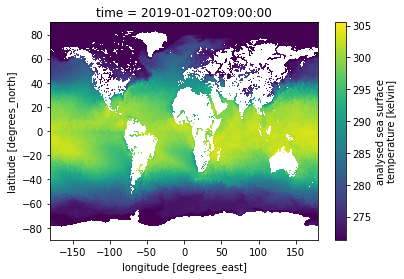

In [11]:
# Plot one time segment of data
mur['analysed_sst'].isel(time=1).plot()

This is the region we wanted!

(array([2.24862546e+08, 6.33942770e+07, 5.57135220e+07, 4.56655160e+07,
        4.20798840e+07, 4.88892480e+07, 7.17874270e+07, 9.81833430e+07,
        1.64858594e+08, 4.65713210e+07]),
 array([271.35   , 274.7678 , 278.1856 , 281.6034 , 285.0212 , 288.439  ,
        291.85678, 295.2746 , 298.69238, 302.1102 , 305.52798],
       dtype=float32),
 <BarContainer object of 10 artists>)

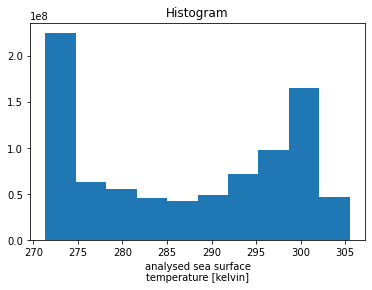

In [12]:
# Histogram
mur['analysed_sst'].plot()

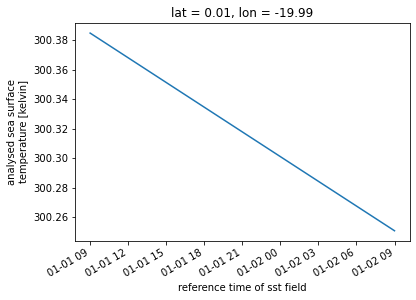

In [14]:
# Plot a single point over time (lat and lon values obtained from xarray summary statistics above)
mur['analysed_sst'].isel(lat=9000, lon=16000).plot()